# aln-enrichment viral
### Jaffe, Fuster et al. 2021

In [1]:
import re, glob, os, math, re, scipy, ecopy, gzip, pysam, random, skbio
from collections import defaultdict
from ete3 import Tree
import numpy as np
import pandas as pd
from Bio import SeqIO, SearchIO
import matplotlib.pyplot as plt
import subprocess as sp
import seaborn as sns
sns.set('notebook')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

import urllib
from Bio import Entrez
from multiprocessing import Pool
from bs4 import BeautifulSoup
Entrez.email = "alexander_jaffe@berkeley.edu"

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        
def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

In [3]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/aln/"
cmdir(rootdir + "dna/virus")

# build genome set

In [72]:
cmdir(rootdir + "dna/virus/genomes")

In [4]:
# read in scaffolds
scaf2bin = pd.read_csv(rootdir + "dna/genomes/LacPavin_0920_ALND.scaffolds_to_bin.tsv", sep="\t")
assembly = {record.description.split(" ")[0]: str(record.seq) for record in
    SeqIO.parse(open("/groups/banfield/projects/environmental/LacPavin/QB3_09_14_20/assembly.d/ALND/megahit/LacPavin_0920_ALND_scaffold_min1000.fa"), "fasta")}

In [190]:
# initialize metadataframe
vdata = defaultdict(list)

for org in scaf2bin["bin"].unique():
    if "vir" in org.lower() or "phage" in org.lower() \
        and "candidate" not in org.lower():
        with open(rootdir + "dna/virus/genomes/" + org + ".fna", "w") as out:
            scaf_count, bin_length= 0,0
            for key, row in scaf2bin[scaf2bin["bin"]==org].iterrows():
                out.write(">%s\n%s\n" %(row["scaffold_name"], assembly[row["scaffold_name"]]))
                bin_length += len(assembly[row["scaffold_name"]])
                scaf_count+=1
            vdata["virus_name"].append(org.strip())
            vdata["scaffold_number"].append(scaf_count)
            vdata["bin_length"].append(bin_length/1000)

In [6]:
# concatenate
call = "cat " + rootdir + "dna/virus/genomes/*" + " > " + rootdir + "dna/virus/all_genomes.fna"
print(call)

cat /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/virus/genomes/* > /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/virus/all_genomes.fna


In [7]:
call = "prodigal -a %s -i %s -m -p meta" %(rootdir + "dna/virus/all_genomes.faa", rootdir + "dna/virus/all_genomes.fna")
print(call)

prodigal -a /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/virus/all_genomes.faa -i /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/virus/all_genomes.fna -m -p meta


# taxonomy

### main workflow

In [218]:
wrapper = open(rootdir + "dna/virus/wrapper.sh", "w")

for refset in glob.glob(rootdir + "dna/virus/ref_sets/*"):
    
    name = os.path.basename(refset).split(".")[0].replace("refseq_", "")
    
    if name != "dnap":
        
        seqlens = [len(record.seq) for record in SeqIO.parse(open(refset), "fasta")]
        median = np.median(seqlens)

        with open(refset.replace(".fasta", ".filtered.fasta"), "w") as out:
            for record in SeqIO.parse(open(refset), "fasta"):
                if (len(record.seq)>=0.5*median) & (len(record.seq)<=1.5*median):
                    clean = record.description.replace(" ", "_").replace("[", "").replace("]","")
                    out.write(">%s\n%s\n" % (clean, str(record.seq)))

        drep = "usearch -cluster_fast %s -id 0.95 -centroids %s -sort length" \
            %(refset.replace(".fasta", ".filtered.fasta"), refset.replace(".fasta", ".centroids.fasta"))
        makedb = "makeblastdb -in " + refset.replace(".fasta", ".centroids.fasta") + \
            " -dbtype prot -out " + refset.replace(".fasta", ".centroids.fasta")
        blast = "blastp -db %s -query %s -out %s -evalue 1e-20 -max_target_seqs 10 -num_threads 20 -sorthits 3 -outfmt 6" \
            %(refset.replace(".fasta", ".centroids.fasta"), rootdir + "dna/virus/all_viral_genomes.faa", refset.replace(".fasta", ".results"))
        extract = "cat %s | cut -f1 | sort | uniq > %s" %(refset.replace(".fasta", ".results"), refset.replace(".fasta", ".headers"))
        pseq = "pullseq -n %s -i %s > %s" %(refset.replace(".fasta", ".headers"), rootdir + "dna/virus/all_viral_genomes.faa", refset.replace(".fasta", ".aln.faa"))
        cat = "cat %s %s > %s" %(refset.replace(".fasta", ".aln.faa"), refset.replace(".fasta", ".centroids.fasta"),refset.replace(".fasta", ".concat.faa"))
        mafft = "mafft --reorder --auto --thread 20 %s > %s" %(refset.replace(".fasta", ".concat.faa"), refset.replace(".fasta", ".mafft"))
        trim = "trimal -in %s -out %s -gt 0.2" %(refset.replace(".fasta", ".mafft"), refset.replace(".fasta", ".trimal"))
        tree = "/shared/software/bin/iqtree -s %s -m TEST -st AA -nt AUTO -ntmax 20 -pre %s" %(refset.replace(".fasta", ".trimal"), refset.replace(".fasta", ""))
        wrapper.write("\n".join([drep, makedb, blast, extract, pseq, cat, mafft, trim, tree]) + "\n")
        
wrapper.close()

### annotate

In [105]:
# get ref taxonomies
accessions = []
for refset in glob.glob(rootdir + "dna/virus/ref_sets/*filtered.fasta"):
    if "dnap" not in refset:
        for record in SeqIO.parse(open(refset), "fasta"):
            if record.description.startswith("gi"):
                accessions.append(record.description.split("_")[1])
            else: accessions.append("_".join(record.description.split("_")[0:2]))

with open(rootdir + "dna/virus/retrieve_genpepts.sh", "w") as out:
    out.write("efetch -db protein -format gp -id %s > %s\n" %(",".join(accessions), rootdir + "dna/virus/protein_info.gbk"))

In [8]:
protein_tax = {}
count=0
for record in SeqIO.parse(open(rootdir + "dna/virus/protein_info.gbk"), "gb"):
    try:
        protein_tax[record.name] = record.annotations["taxonomy"][5]
    except: count+=1

print("%s records excluded at this taxonomic level." %(count))

31 records excluded at this taxonomic level.


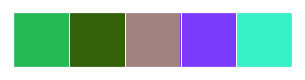

In [9]:
# set up colors
colors = {}

for tax in set(protein_tax.values()):
    if list(protein_tax.values()).count(tax) >=5:
        colors[tax] = "#%06x" % random.randint(0, 0xFFFFFF)
    else: colors[tax] = "grey"
    
sns.palplot([color for color in colors.values() if color != "grey"])

In [500]:
# modify trees
for aln in glob.glob(rootdir + "dna/virus/ref_sets/*mafft"):
    
    if "dnap" not in aln:
        
        itol = open(aln.replace(".mafft", ".itol.txt"), "w")
        itol.write("TREE_COLORS\nSEPARATOR TAB\nDATA\n")
        
        for record in SeqIO.parse(open(aln), "fasta"):
            
            if record.description.startswith("gi"):
                ident = "_".join(record.description.split("_")[3:5]).split(".")[0]
            else: ident = "_".join(record.description.split("_")[0:2]).split(".")[0]
            tax = protein_tax[ident] if ident in protein_tax else "None"
            if tax != "None":
                itol.write(record.description.split(" ")[0] + "\trange\t%s\t%s\n" %(colors[tax], tax))
                
        itol.close()

### curate

In [494]:
# generate curation sheet
curation_info = defaultdict(list)

for aln in glob.glob(rootdir + "dna/virus/ref_sets/*mafft"):
    if "dnap" not in aln:
        for record in SeqIO.parse(open(aln), "fasta"):
            if "ALND" in record.description:
                curation_info["dataset"].append(os.path.basename(aln).split(".")[0].split("_")[1])
                curation_info["gene"].append(record.description.split(" ")[0])
                curation_info["scaffold_name"].append(scaffold(record.description.split(" ")[0]))

curation_df = pd.DataFrame(curation_info)
curation_df = curation_df.merge(scaf2bin[["scaffold_name", "bin"]], how="left")[["bin", "scaffold_name", "gene", "dataset"]]
curation_df["lineage"] = ""
curation_df.to_csv(rootdir + "dna/virus/viral_curation_raw.tsv", sep="\t", index=False)

In [200]:
# read in manual curation + reconcile
tinfo = defaultdict(list)
curated_df = pd.read_csv(rootdir + "dna/virus/viral_curation.tsv", sep="\t").fillna("None")

for bin in curated_df["bin"].unique():
    
    subtable = curated_df[curated_df["bin"]==bin].drop_duplicates(["bin", "dataset"])
    tinfo["virus_name"].append(bin.strip())
    tinfo["viral_lineage"].append(subtable["lineage"].to_list()[0])
    tinfo["marker_gene"].append(", ".join(subtable["dataset"].to_list()))
    
tdf = pd.DataFrame(tinfo)
tdf.head()

,virus_name,viral_lineage,marker_gene
0,LacPavin_0920_ALND_Bacteroidetes_Phage_34_33,probable Caudovirales,"mcp, terminase"
1,LacPavin_0920_ALND_Phage_34_28,probable Caudovirales,"mcp, terminase"
2,LacPavin_0920_Bacteroidetes_Phage_31_13,probable Caudovirales,"mcp, terminase"
3,LacPavin_0920_ALND-Phage-like-45-26,probable Caudovirales,mcp
4,LacPavin_0920_ALND_Phage_41_43,probable Caudovirales,"mcp, terminase"


### extract euk virus mcp

In [11]:
euk_viruses = ["Artverviricota", "Baculoviridae", "Nucleocytoviricota", \
               "Pisuviricota", "Peploviricota", "Kitrinoviricota", "Cossaviricota", "Duplornaviricota"]
euk_info = defaultdict(list)

for record in SeqIO.parse(open(rootdir + "dna/virus/protein_info.gbk"), "gb"):
    for lineage in euk_viruses:
        if lineage in record.annotations["taxonomy"]:
            euk_info["accession"].append(record.id.split(".")[0])
            euk_info["name"].append(record.description)
            euk_info["taxonomy"].append(";".join(record.annotations["taxonomy"]))
            break

euk_df = pd.DataFrame(euk_info)
euk_df.head()

,accession,name,taxonomy
0,YP_010087895,major capsid protein [Lymphocystis disease vir...,Viruses;Varidnaviria;Bamfordvirae;Nucleocytovi...
1,YP_010084900,major capsid Protein [Shrimp hemocyte iridesce...,Viruses;Varidnaviria;Bamfordvirae;Nucleocytovi...
2,YP_009702054,major capsid protein [Heliothis virescens asco...,Viruses;Varidnaviria;Bamfordvirae;Nucleocytovi...
3,YP_009507024,major capsid protein [Tunisvirus fontaine2],Viruses;Varidnaviria;Bamfordvirae;Nucleocytovi...
4,YP_009345261,major capsid protein [Noumeavirus],Viruses;Varidnaviria;Bamfordvirae;Nucleocytovi...


In [492]:
with open(rootdir + "dna/virus/euk_virus_mcp.faa", "w") as outfile:
    for record in SeqIO.parse(open(rootdir + "dna/virus/ref_sets/refseq_mcp.centroids.fasta"), "fasta"):
        if record.description.startswith("gi"):
            ident = "_".join(record.description.split("_")[3:5]).split(".")[0]
        else: ident = "_".join(record.description.split("_")[0:2]).split(".")[0]
        if ident in euk_df["accession"].to_list():
            outfile.write(">%s\n%s\n" %(ident, str(record.seq)))
            
euk_df.to_csv(rootdir + "dna/virus/euk_virus_mcp.tsv", sep="\t", index=False)

# host assignment

### crispr

In [85]:
curated_md = pd.read_csv(rootdir + "tables/aln_genome_metadata_curated.tsv", sep="\t")
curated_phages = scaf2bin[scaf2bin["bin"].str.contains("Phage") & (~scaf2bin["bin"].str.contains("Candidate"))]

In [88]:
# parse blast hits
bresults = skbio.io.read(rootdir + "dna/crispr/query.for.targeting.search.fasta.blastn.spacers.fasta", format="blast+6", into=pd.DataFrame, default_columns=True)
# read in spacer length
spacer_lens = {record.description.split(" ")[0]:len(record.seq) for record in SeqIO.parse(open(rootdir + "dna/crispr/spacers.fasta"), "fasta")}
bresults["spacer_len"] = bresults["sseqid"].map(spacer_lens)
bresults["spacer_coverage"] = bresults.apply(lambda x: abs((x["send"] - x["sstart"])/x["spacer_len"]*100), axis=1)
# filter hits
bfilt = bresults[(bresults["spacer_coverage"]>=90) & (bresults["mismatch"] <= 2)]
bfilt["targeting_scaffold"] = bfilt["sseqid"].apply(lambda x: x.split("_region")[0])
bfilt = bfilt.merge(scaf2bin[["scaffold_name", "bin"]], how="left", left_on="targeting_scaffold", right_on="scaffold_name").drop("scaffold_name", axis=1)
# select down
bfilt = bfilt.merge(curated_md[["genome", "lineage"]], how="left", left_on="bin", right_on="genome").drop("genome", axis=1)
bfilt_sub = bfilt[bfilt["qseqid"].isin(curated_phages["scaffold_name"].to_list())]
bfilt_sub

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,spacer_len,spacer_coverage,targeting_scaffold,bin,lineage
0,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,100.000,34.0,0.0,0.0,46288.0,46321.0,1.0,34.0,7.440000e-11,62.6,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38,Planctomycetes
1,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,100.000,33.0,0.0,0.0,46288.0,46320.0,1.0,33.0,2.600000e-10,60.8,34,94.117647,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38,Planctomycetes
2,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,97.059,34.0,1.0,0.0,46288.0,46321.0,1.0,34.0,3.170000e-09,58.1,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38,Planctomycetes
3,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,97.059,34.0,1.0,0.0,46288.0,46321.0,1.0,34.0,3.170000e-09,58.1,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38,Planctomycetes
4,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,97.059,34.0,1.0,0.0,46288.0,46321.0,1.0,34.0,3.170000e-09,58.1,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38,Planctomycetes


### gene content

In [530]:
# write out phage proteins + annotate
scafs = set()
with open(rootdir + "dna/virus/all_phage_proteins.faa", "w") as out:
    for record in SeqIO.parse(open(rootdir + "dna/virus/all_viral_genomes.faa"), "fasta"):
        
        scaf = scaffold(record.description.split(" ")[0])
        if scaf in curated_phages["scaffold_name"].to_list():
            out.write(">%s\n%s\n" %(record.description, str(record.seq)))
            scafs.add(scaf)
            
call = "diamond blastp -d /groups/banfield/users/clarelou/databases/UniRef100/uniref100.translated.dmnd " + \
            "-q %s -o %s --threads 20 -b8 -c1" %(rootdir + "dna/virus/all_phage_proteins.faa", rootdir + "dna/virus/all_phage_proteins.matches")
print(call)

diamond blastp -d /groups/banfield/users/clarelou/databases/UniRef100/uniref100.translated.dmnd -q /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/virus/all_phage_proteins.faa -o /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/virus/all_phage_proteins.matches --threads 20 -b8 -c1


In [48]:
# concatenate + collect taxonomy
dmnd = skbio.io.read(rootdir + "dna/virus/all_phage_proteins.matches", format="blast+6", into=pd.DataFrame, default_columns=True)
# compute coverage
faalens = {record.description.split(" ")[0]: len(record.seq) for record in SeqIO.parse(open(rootdir + "dna/virus/all_phage_proteins.faa"), "fasta")}
dmnd["qlen"] = dmnd["qseqid"].map(faalens)
dmnd["qcov"] = dmnd.apply(lambda x: (x["qend"]-x["qstart"])/x["qlen"], axis=1)
# choose best hits for each
dmnd = dmnd.sort_values(["bitscore", "qcov"], ascending=[False,False]).drop_duplicates("qseqid")
# filter for min cov /eval
dmnd = dmnd[(dmnd["evalue"]<1e-10) & (dmnd["qcov"]>0.70)]
dmnd.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,qcov
10515,LacPavin_0920_ALND_scaffold_104729_65,A0A6C0BAW2_1070528_1070528,77.9,1222.0,262.0,3.0,17.0,1236.0,1.0,1216.0,0.0,1976.0,1239,0.983858
17520,LacPavin_0920_ALND_scaffold_745543_82,A0A419D9S4_2093353_2093353,78.6,1090.0,232.0,1.0,3.0,1091.0,1.0,1090.0,0.0,1752.0,1093,0.995425
10413,LacPavin_0920_ALND_scaffold_104729_57,A0A6C0BBS7_1070528_1070528,55.5,1504.0,615.0,12.0,6.0,1501.0,2.0,1459.0,0.0,1621.0,1502,0.995340
17445,LacPavin_0920_ALND_scaffold_745543_79,A0A2E2NBR6_2026778_2026778,73.0,1017.0,267.0,5.0,3.0,1018.0,1.0,1010.0,0.0,1488.0,1020,0.995098
10565,LacPavin_0920_ALND_scaffold_104729_68,A0A6C0IEI8_1070528_1070528,73.5,774.0,192.0,1.0,4.0,764.0,8.0,781.0,0.0,1186.0,839,0.905840


In [17]:
with open(rootdir + "/dna/virus/uniref_search.sh", "w") as out:
    
    accs = []
    for item in dmnd["sseqid"].unique():
        if item.split("_")[-2] != "None":
            accs.append(item.split("_")[-2])
        else: accs.append(item.split("_")[-1])
    accs_unique = list(set(accs))
    
    out.write("efetch -db taxonomy -mode xml -id %s > %s\n" %(",".join(accs_unique), \
        rootdir + "/dna/virus/uniref_results.xml"))

In [49]:
lineage_info = defaultdict(list)

for xml in glob.glob(rootdir + "dna/virus/uniref_results.xml"):
    
    for block in BeautifulSoup(open(xml), "xml").findAll("Taxon"):
        
        lineage, phylum = "None", "None"

        if block.find("Lineage"):
            lineage = block.find("Lineage").string

        for level in block.findAll("Taxon"):
            if level.find("Rank").string=="phylum":
                phylum = level.find("ScientificName").string

        lineage_info["taxid"].append(block.find("TaxId").string)
        lineage_info["lineage"].append(lineage)
        lineage_info["phylum"].append(phylum)

lineage_df = pd.DataFrame(lineage_info).query("lineage!='None'")

In [50]:
# add in
dmnd["taxid"] = dmnd["sseqid"].apply(lambda x: x.split("_")[-2] if x.split("_")[-2] != 'None' else x.split("_")[-1])
dmnd["scaffold"] = dmnd["qseqid"].apply(scaffold)
dmnd = dmnd.merge(lineage_df, how="left", on="taxid").fillna("None")
dmnd.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,qcov,taxid,scaffold,lineage,phylum
0,LacPavin_0920_ALND_scaffold_104729_65,A0A6C0BAW2_1070528_1070528,77.9,1222.0,262.0,3.0,17.0,1236.0,1.0,1216.0,0.0,1976.0,1239,0.983858,1070528,LacPavin_0920_ALND_scaffold_104729,unclassified entries; unclassified sequences; ...,None
1,LacPavin_0920_ALND_scaffold_745543_82,A0A419D9S4_2093353_2093353,78.6,1090.0,232.0,1.0,3.0,1091.0,1.0,1090.0,0.0,1752.0,1093,0.995425,2093353,LacPavin_0920_ALND_scaffold_745543,cellular organisms; Bacteria; Bacteria incerta...,None
2,LacPavin_0920_ALND_scaffold_104729_57,A0A6C0BBS7_1070528_1070528,55.5,1504.0,615.0,12.0,6.0,1501.0,2.0,1459.0,0.0,1621.0,1502,0.995340,1070528,LacPavin_0920_ALND_scaffold_104729,unclassified entries; unclassified sequences; ...,None
3,LacPavin_0920_ALND_scaffold_745543_79,A0A2E2NBR6_2026778_2026778,73.0,1017.0,267.0,5.0,3.0,1018.0,1.0,1010.0,0.0,1488.0,1020,0.995098,2026778,LacPavin_0920_ALND_scaffold_745543,cellular organisms; Bacteria; PVC group; Planc...,Planctomycetes
4,LacPavin_0920_ALND_scaffold_104729_68,A0A6C0IEI8_1070528_1070528,73.5,774.0,192.0,1.0,4.0,764.0,8.0,781.0,0.0,1186.0,839,0.905840,1070528,LacPavin_0920_ALND_scaffold_104729,unclassified entries; unclassified sequences; ...,None


In [51]:
orf_counts = {}

for record in SeqIO.parse(open(rootdir + "dna/virus/all_phage_proteins.faa"), "fasta"):
    scaf = scaffold(record.description.split(" ")[0])
    if scaf not in orf_counts.keys():
        orf_counts[scaf] = 1
    else: orf_counts[scaf] +=1

In [80]:
host_info = defaultdict(list)
prok_phyla = lineage_df[lineage_df["lineage"].str.contains("Bacteria") | \
                lineage_df["lineage"].str.contains("Archaea")]["phylum"].unique()

for scaf in dmnd["scaffold"].unique():
    
    subtable = dmnd[dmnd["scaffold"]==scaf].groupby(["scaffold", "phylum"], \
        as_index=False).aggregate({"qseqid":"count"}).sort_values("qseqid", ascending=False)
    # filter down to only prok - no virus, euk
    subtable = subtable[subtable["phylum"].isin(prok_phyla) & (subtable["phylum"]!='None')]
    host_info["scaffold"].append(scaf)
    host_info["winner"].append(subtable["phylum"].iloc[0])
    host_info["winner_perc"].append((subtable["qseqid"].iloc[0]/orf_counts[scaf])*100)
    
    if len(subtable) >1:
        host_info["runnerup"].append(subtable["phylum"].iloc[1])
        host_info["runnerup_perc"].append((subtable["qseqid"].iloc[1]/orf_counts[scaf])*100)
    else:
        host_info["runnerup"].append("None")
        host_info["runnerup_perc"].append(0)

hdf = pd.DataFrame(host_info)
hdf_clean = hdf[round(hdf["winner_perc"]/hdf["runnerup_perc"],3)>= 3]
hdf_clean.head()

,scaffold,winner,winner_perc,runnerup,runnerup_perc
1,LacPavin_0920_ALND_scaffold_745543,Planctomycetes,40.163934,Proteobacteria,12.295082
5,LacPavin_0920_ALND_scaffold_44158,Bacteroidetes,11.928429,Spirochaetes,2.584493
9,LacPavin_0920_ALND_scaffold_1090059,Proteobacteria,34.579439,Actinobacteria,0.934579
13,LacPavin_0920_ALND_scaffold_37366,Planctomycetes,14.285714,Proteobacteria,4.761905
16,LacPavin_0920_ALND_scaffold_1114115,Proteobacteria,12.301587,Actinobacteria,0.793651


### put them together

In [203]:
gene_content = hdf_clean[["scaffold", "winner"]].rename(columns={"winner":"predicted_host"})
gene_content["method"] = "gene content"
crispr = bfilt_sub[["qseqid", "lineage"]].drop_duplicates().rename(columns={"qseqid":"scaffold", "lineage":"predicted_host"})
crispr["method"] = "crispr targeting"
combined_predictions = pd.concat([gene_content, crispr])
combined_predictions = combined_predictions.merge(scaf2bin[["scaffold_name", "bin"]], \
                           how="left", left_on="scaffold", right_on="scaffold_name").drop("scaffold_name", axis=1)
combined_predictions

,scaffold,predicted_host,method,bin
0,LacPavin_0920_ALND_scaffold_745543,Planctomycetes,gene content,LacPavin_0920_ALND_Phage-like_AC_TGA_55_18
1,LacPavin_0920_ALND_scaffold_44158,Bacteroidetes,gene content,LacPavin_0920_ALND-Phage-like-45-26
2,LacPavin_0920_ALND_scaffold_1090059,Proteobacteria,gene content,LacPavin_0920_ALND_Phage-like_59_11
3,LacPavin_0920_ALND_scaffold_37366,Planctomycetes,gene content,LacPavin_0920_ALND_Likely_Planctomycete_Phage_...
4,LacPavin_0920_ALND_scaffold_1114115,Proteobacteria,gene content,LacPavin_0920_Potentially_Complete_Phage-like-...
5,LacPavin_0920_ALND_scaffold_64753,Planctomycetes,crispr targeting,LacPavin_0920_ALND_Phage_44_31


In [204]:
# fill in those missing
other_info = defaultdict(list)

for vp in vdata["virus_name"]:
    if vp not in combined_predictions["bin"].to_list():
        other_info["bin"].append(vp)
        other_info["predicted_host"].append("unknown Bacteria" \
                                     if "Phage" in vp else "unknown Eukaryota")
        for field in ["scaffold", "method"]:
            other_info[field].append("None")

combined_predictions = pd.concat([combined_predictions, pd.DataFrame(other_info)])

# transcriptome data

See viral section below to build final viral genome set, then build bt index.

In [84]:
# map reads to assembly
fwd_path = "/groups/banfield/sequences/2020/LacPavin_0920_ALNR/raw.d/LacPavin_0920_ALNR_trim_clean.PE.1.fastq.gz"
mapping = "/shared/software/bin/bowtie2 -p 20 -x " + rootdir + "rna/all_viral_genomes.fna -1 " + \
    fwd_path + " -2 " + fwd_path.replace(".1.", ".2.") + " 2> " + rootdir + "rna/viral_rna_mapping.log | " + \
    "/shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > " + rootdir + "rna/viral_rna_mapping.bam"
print(mapping)

/shared/software/bin/bowtie2 -p 20 -x /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/all_viral_genomes.fna -1 /groups/banfield/sequences/2020/LacPavin_0920_ALNR/raw.d/LacPavin_0920_ALNR_trim_clean.PE.1.fastq.gz -2 /groups/banfield/sequences/2020/LacPavin_0920_ALNR/raw.d/LacPavin_0920_ALNR_trim_clean.PE.2.fastq.gz 2> /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/viral_rna_mapping.log | /shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/viral_rna_mapping.bam


In [88]:
# generate sorted bam + idx
sort = "/shared/software/bin/samtools sort --threads 20 " + rootdir + "rna/viral_rna_mapping.bam > " + rootdir + "rna/viral_rna_mapping.sorted.bam"
index = "/shared/software/bin/samtools index -@ 20 " + rootdir + "rna/viral_rna_mapping.sorted.bam"
print(index)

/shared/software/bin/samtools index -@ 20 /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/viral_rna_mapping.sorted.bam


In [144]:
# read in contig wise using coverm
coverm = "coverm genome -f " + rootdir + "dna/virus/genomes/* --min-read-percent-identity 0.95" + \
            " --min-covered-fraction 0 --output-format sparse -b " + rootdir + "rna/viral_rna_mapping.sorted.bam -m" + \
            " count mean covered_fraction length rpkm > " + rootdir + "rna/viral_coverage_table.csv"
print(coverm)

coverm genome -f /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/virus/genomes/* --min-read-percent-identity 0.95 --min-covered-fraction 0 --output-format sparse -b /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/viral_rna_mapping.sorted.bam -m count mean covered_fraction length rpkm > /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/viral_coverage_table.csv


In [191]:
# read in
viral_cov_table = pd.read_csv(rootdir + "rna/viral_coverage_table.csv", sep="\t")
viral_cov_table.sort_values("Mean", ascending=False).head()

,Sample,Genome,Read Count,Mean,Covered Fraction,Length,RPKM
33,viral_rna_mapping.sorted,LacPavin_0920_Potentially_Complete_Phage-like-...,354,0.244850,0.078292,161510,1829.56150
13,viral_rna_mapping.sorted,LacPavin_0920_ALND_Phage_44_31,122,0.199959,0.072826,78461,1297.92370
21,viral_rna_mapping.sorted,LacPavin_0920_ALND_Potentially_Complete_Phage_...,50,0.062638,0.035890,105294,396.37800
12,viral_rna_mapping.sorted,LacPavin_0920_ALND_Phage_41_43,145,0.061800,0.028148,318533,379.97653
19,viral_rna_mapping.sorted,LacPavin_0920_ALND_Phage-like_AC_TGA_55_18,24,0.028909,0.006519,113056,177.19880


# finalize

### checkv

In [217]:
cmdir(rootdir + "/dna/virus/checkv")

In [222]:
# write out single contig genomes
with open(rootdir + "dna/virus/single_contig_genomes.fna", "w") as out:
    for genome in glob.glob(rootdir + "dna/virus/genomes/*"):
        scafs = [record for record in SeqIO.parse(open(genome), "fasta")]
        if len(scafs) ==1:
            out.write(">%s\n%s\n" %(scafs[0].description, str(scafs[0].seq)))

In [221]:
call = "checkv end_to_end %s %s -t 20 -d %s" %(rootdir + "dna/virus/single_contig_genomes.fna", rootdir + "/dna/virus/checkv", "/groups/banfield/projects/environmental/LacPavin/analysis/viral/checkv/checkv-db-v1.0")
print(call)

checkv end_to_end /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/virus/single_contig_genomes.fna /groups/banfield/projects/environmental/LacPavin/analysis/aln//dna/virus/checkv -t 20 -d /groups/banfield/projects/environmental/LacPavin/analysis/viral/checkv/checkv-db-v1.0


In [243]:
# read in results
cvresults = pd.read_csv(rootdir + "dna/virus/checkv/quality_summary.tsv", sep="\t")
cvresults = cvresults.merge(scaf2bin, how="left", left_on="contig_id", right_on="scaffold_name").drop("scaffold_name", axis=1)
cvsub = cvresults[["bin", "checkv_quality", "completeness"]].rename(columns={"completeness":"checkv_completeness_percent", "bin":"virus_name"})
cvsub.head()

,virus_name,checkv_quality,checkv_completeness_percent
0,LacPavin_0920_ALND_Potentially_Complete_Phage_...,Medium-quality,70.86
1,LacPavin_0920_Potentially_Complete_Phage-like-...,Complete,100.00
2,LacPavin_0920_ALND_Potentially_Complete_Phage_...,Complete,100.00
3,LacPavin_0920_Bacteroidetes_Phage_31_13,Medium-quality,83.71
4,LacPavin_0920_ALND_Phage-like_59_11,Complete,100.00


### final table

In [244]:
vdf = pd.DataFrame(vdata).sort_values("bin_length", ascending=False)
vdf = vdf.merge(combined_predictions, how="left", left_on="virus_name", right_on="bin").drop("bin", axis=1)
vdf = vdf.merge(tdf, how="left").merge(viral_cov_table[["Genome", "Mean", "Covered Fraction"]], how="left", left_on="virus_name", right_on="Genome").drop("Genome", axis=1)
vdf = vdf.merge(cvsub, how="left").fillna("None")
vdf["id"] = vdf["virus_name"].apply(lambda x: vdf["virus_name"].to_list().index(x))
vdf["virus_id"] = vdf["id"].apply(lambda x: "V" + str(x+1))
vdf["virus_name"] = vdf["virus_name"].apply(lambda x: x.replace("LacPavin", "LakeFargette"))

In [245]:
# for supplementary
viral_supp = vdf[["virus_name", "virus_id", "bin_length", "scaffold_number", "checkv_quality", "checkv_completeness_percent", "viral_lineage", \
                  "marker_gene", "predicted_host", "method", "Mean", "Covered Fraction"]].rename(columns={"bin_length":"bin_length_kbp", "method":"prediction_method", "Mean":"rna_coverage_mean", "Covered Fraction":"rna_coverage_breadth"}).fillna("None")
viral_supp.to_csv(rootdir + "tables/viral_supp.tsv", sep="\t", index=False)
viral_supp.head()

,virus_name,virus_id,bin_length_kbp,scaffold_number,checkv_quality,checkv_completeness_percent,viral_lineage,marker_gene,predicted_host,prediction_method,rna_coverage_mean,rna_coverage_breadth
0,LakeFargette_0920_ALND_Phaeocystis_Virus_25_19,V1,453.941,1,High-quality,97.1,None,mcp,unknown Eukaryota,None,0.002428,0.001152
1,LakeFargette_0920_ALND-Phage-like-45-26,V2,365.116,1,Medium-quality,88.82,probable Caudovirales,mcp,Bacteroidetes,gene content,0.009258,0.004484
2,LakeFargette_0920_ALND_Euk_Virus_uncertain_35_24,V3,328.689,3,None,None,None,mcp,unknown Eukaryota,None,0.004625,0.002361
3,LakeFargette_0920_ALND_Phage_41_43,V4,318.533,1,Medium-quality,89.55,probable Caudovirales,"mcp, terminase",unknown Bacteria,None,0.061800,0.028148
4,LakeFargette_0920_ALND_Euk-Virus-like_43_13,V5,292.118,1,Low-quality,39.18,None,mcp,unknown Eukaryota,None,0.005281,0.001749


### plot

In [208]:
raw = pd.read_csv(rootdir + "/dna/ggkbase_color_scheme.uppercase.csv", header=None, names=["lineage", "hex"])
ggcolors = {row["lineage"]: row["hex"] for key, row in raw.iterrows()}
ggcolors["unknown Eukaryota"] = ggcolors["Eukaryota"]
ggcolors["unknown Bacteria"] = "lightgrey"

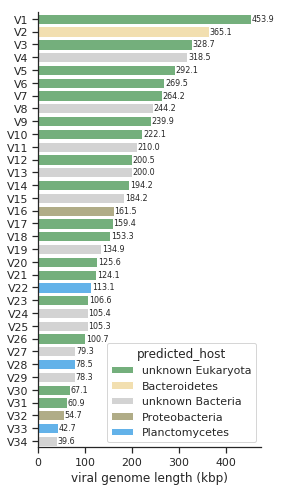

In [211]:
# plot out information
sns.set_style("ticks", {'font.family':'sans-serif'})
plt.figure(figsize=[4,8])
g = sns.barplot(y="virus_id", x="bin_length", hue="predicted_host", palette=ggcolors,
                data=vdf.sort_values("bin_length", ascending=False), orient="h", dodge=False)
#g.set(yticks=[])
for key, row in vdf.sort_values("bin_length", ascending=False).iterrows():
    plt.text(row["bin_length"]+1.5,row["id"]+.175, round(row["bin_length"], 1), fontsize=8)
plt.ylabel("")
plt.xlabel("viral genome length (kbp)")
#plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', fontsize=9)
#plt.xscale("log")
sns.despine()
plt.savefig(rootdir + "dna/figures/virus_sizes.svg", format="svg")